# Denpasar Weather Forecasting with TensorFlow

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import io

mpl.rcParams['figure.figsize'] = (12, 5)
mpl.rcParams['axes.grid'] = False

## The weather dataset

This dataset is collected from https://openweathermaps.org pointed in Denpasar, Bali. The dataset contains **hourly** weather data from January 1st 1990 until January 7th 2020. Originally there are 32 features, although has been reduced the unnecessary features to  11 features as shown below. You can access this data at https://www.kaggle.com/cornflake15/denpasarbalihistoricalweatherdata

In [3]:
usecols = ['dt_iso', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
           'clouds_all', 'weather_main', 'weather_description']
df = pd.read_csv('openweatherdata-denpasar-1990-2020v0.1.csv', parse_dates=True, index_col='dt_iso', usecols=usecols)
df.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description
dt_iso,,,,,,,,,,
1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86,1.36,225,98,Rain,light rain
1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84,2.09,247,91,Rain,light rain
1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84,2.44,262,94,Rain,light rain
1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82,2.29,271,94,Rain,light rain
1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82,1.71,274,76,Clouds,broken clouds


In [4]:
df.shape

(264924, 10)

**Data Split Function**

In [5]:
# Split the data by percentage
def num_data_train(percentage, data_length):
    num_data = percentage / 100 * data_length
    return int(num_data)

From this section, the code is adapted from **Time Series Tensorflow Tutorial**.

Source: https://www.tensorflow.org/tutorials/structured_data/time_series

## Forecast a univariate time series

In this part, we tested how ML method works at time series data. We conducted simple forecasting on single feature (temperature).

**Split the data**

In [6]:
TRAIN_SPLIT = num_data_train(70, df.shape[0]) # Split 70% of the data for training
tf.random.set_seed(13) # Setting seed to ensure reproducibility
print('Length of Data Train: {}'.format(TRAIN_SPLIT))

Length of Data Train: 185446


In [7]:
# Train a model using a single feature (temperature)
dt_temp = df['temp']
dt_temp.tail()

dt_iso
2020-01-07 19:00:00    27.0
2020-01-07 20:00:00    27.0
2020-01-07 21:00:00    28.0
2020-01-07 22:00:00    28.0
2020-01-07 23:00:00    28.0
Name: temp, dtype: float64

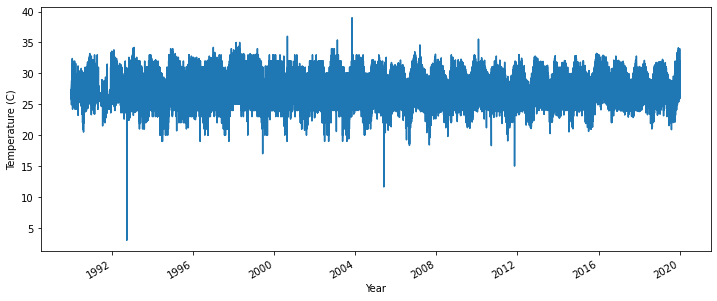

In [8]:
dt_temp.plot(subplots=True)
plt.xlabel('Year')
plt.ylabel('Temperature (C)')
plt.show()

In [9]:
# Convert the dataframe into numpy array
array_temp = dt_temp.values
print(array_temp[:10]) # Print 10 elements for checking

[25.82 26.2  26.45 26.8  27.04 27.23 27.32 27.29 27.34 27.23]


In [10]:
# Scaling the features
array_temp_mean = array_temp[:TRAIN_SPLIT].mean()
array_temp_std = array_temp[:TRAIN_SPLIT].std()
print('Training Data Mean: {}'.format(array_temp_mean))
print('\nTraining Data Std.Dev: {}'.format(array_temp_std))

Training Data Mean: 27.1836268239811

Training Data Std.Dev: 1.9980058874922433


In [11]:
# Standardize the data
array_temp = (array_temp - array_temp_mean) / array_temp_std
print(array_temp)

[-0.6824939  -0.49230427 -0.36717951 ...  0.40859398  0.40859398
  0.40859398]


In [12]:
# create a function that return the time windows for the model to train on
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In this part, the model will be given the last **`n`** recorded temperature observation, and needs to learn to predict the temperature at the next **`m`** time step.

In [13]:
# Create the univariate model
data_past_history = 30 # number of last recorded data (n)
data_future_target = 0 # number of time step (m)

x_train, y_train = univariate_data(array_temp, 0, TRAIN_SPLIT, data_past_history, data_future_target)
x_val, y_val = univariate_data(array_temp, TRAIN_SPLIT, None, data_past_history, data_future_target)

print('x_train length: {} shape: {}'.format(len(x_train), x_train.shape))
print('y_train length: {} shape: {}'.format(len(y_train), y_train.shape))
print('x_val length: {} shape: {}'.format(len(x_val), x_val.shape))
print('y_val length: {} shape: {}'.format(len(y_val), y_val.shape))

x_train length: 185416 shape: (185416, 30, 1)
y_train length: 185416 shape: (185416,)
x_val length: 79448 shape: (79448, 30, 1)
y_val length: 79448 shape: (79448,)


Now that the data has been created, The information given to the network is given in blue, and it must predict the value at the red cross.

In [14]:
def create_time_steps(length):
    return list(range(-length, 0))

In [15]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
       
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'c:\\users\\rudyh\\documents\\python_code\\lib\\site-packages\\matplotlib\\pyplot.py'>

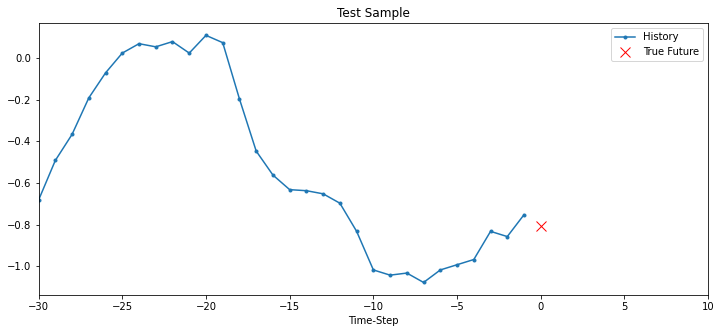

In [16]:
show_plot([x_train[0], y_train[0]], 0, 'Test Sample')

**We compared two models, first is simple `sequential` model with 2 layers and second is simple `LSTM` model with 1 layer.**

In [17]:
from tensorflow.keras import layers
tf.keras.backend.clear_session()  # For easy reset of notebook state.

# Normal Sequential model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=x_train.shape[-2:]), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compare with simple LSTM Model, according to several sources LSTM is suitable for modeling time series data
model_2 = tf.keras.models.Sequential(
    [tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]), tf.keras.layers.Dense(1)]
)
model_1.summary()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 16)            32        
_________________________________________________________________
dense_1 (Dense)              (None, 30, 16)            272       
_________________________________________________________________
dense_2 (Dense)              (None, 30, 1)             17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 

In [18]:
model_1.compile(optimizer='adam', loss='mae')
model_2.compile(optimizer='adam', loss='mae')

**Further reading:**
    
    1. https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
    2. https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list/45944225
    3. https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [19]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

datatrain = tf.data.Dataset.from_tensor_slices((x_train, y_train))
datatrain = datatrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

dataval = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataval = dataval.batch(BATCH_SIZE).repeat()

In [20]:
EPOCHS = 10
STEPS_PER_EPOCH = 200 # number of time steps
VALIDATION_STEPS = 50

# Train the model
model_1_history = model_1.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)
model_2_history = model_2.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6002 - val_loss: 0.7155
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.8129 - val_loss: 0.7022
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7974 - val_loss: 0.7008
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6201 - val_loss: 0.7512
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7549 - val_loss: 0.7077
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7993 - val_loss: 0.7036
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7809 - val_loss: 0.7023
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5792 - val_loss: 0.7206
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.8124 - val_loss: 0.7034
Epoch 10/10
200/200 [==============================] - 2

In [21]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

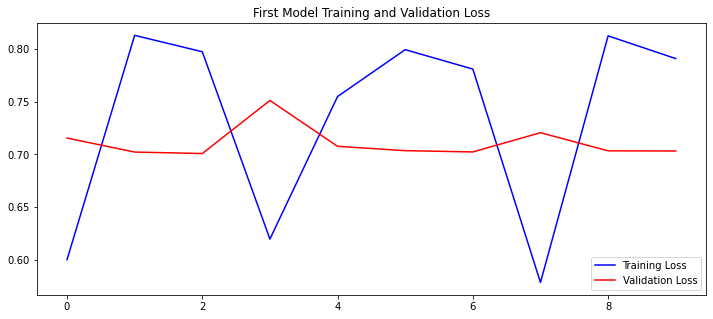

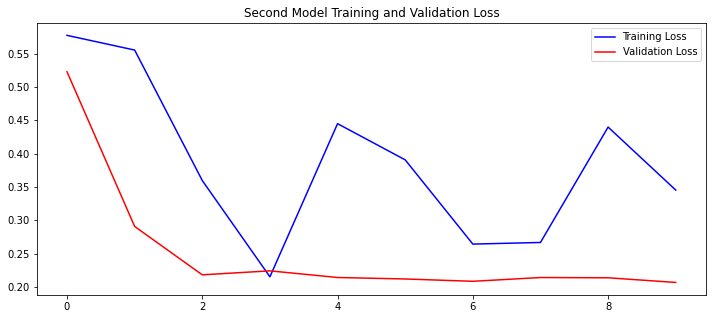

In [22]:
plot_train_history(model_1_history, 'First Model Training and Validation Loss')
plot_train_history(model_2_history, 'Second Model Training and Validation Loss')

**The graph above indicates that the model performance was not really good because we only use single feature (temperature)**
First model is not really clear whether it is overfit or underfit, but the second model clealy underfit. Second model need hyperparameter tuning or because it used only single feature.

In the next section we will use multi-feature/multivariate forecasting.

Further readings:
    1. https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss
    2. https://stackoverflow.com/questions/48226086/training-loss-and-validation-loss-in-deep-learning

# Multivariate Forecasting

In this part we decided to use multivariate forecasting to see how the LSTM method performs. We use five features that has the most important parts in forecasting weather, i.e, **average air temperature** (`temp`), **minimum air temperature** (`temp_min`), **maximum air temperature** (`temp_max`), **air pressure** (`pressure`), and **air humidity** (`humidity`).

In [23]:
# df_multivariate = df.drop(['weather_main', 'weather_description'], axis=1)
df_multivariate = df[['temp', 'temp_min', 'temp_max', 'pressure', 'humidity']]
df_multivariate.head()

,temp,temp_min,temp_max,pressure,humidity
dt_iso,,,,,
1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86
1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84
1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84
1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82
1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82


Analyze the features correlation with correlation matrix

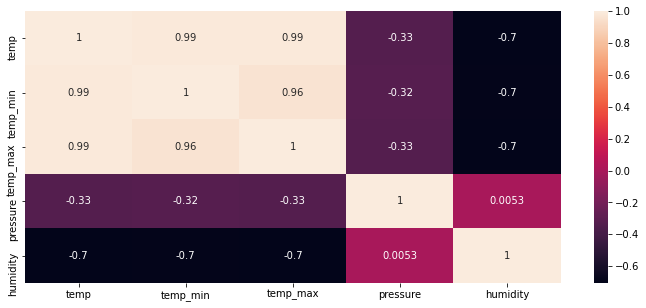

In [24]:
import seaborn as sns

sns.heatmap(df_multivariate.corr(), annot=True)
plt.show()

We didn't used 2020 data because there was contain only seven days of data therefore we used data from January 1st 1990 until December 31st 2019.

In [25]:
# Don't use data in 2020
df_multivariate = df_multivariate.loc['1990':'2019']
df_multivariate.tail()

,temp,temp_min,temp_max,pressure,humidity
dt_iso,,,,,
2019-12-31 19:00:00,27.08,27.0,27.2,1009.0,88
2019-12-31 20:00:00,26.64,26.0,27.0,1009.0,94
2019-12-31 21:00:00,26.00,26.0,26.0,1009.0,94
2019-12-31 22:00:00,26.00,26.0,26.0,1009.0,94
2019-12-31 23:00:00,27.00,27.0,27.0,1010.0,88


In [26]:
# Convert the dataframe to numpy array
# df_multivariate = df_multivariate.drop('date', axis=1)
dt_multivariate = df_multivariate.values
print('Number of dataset: {}'.format(len(df_multivariate)))
print('10 samples of data: \n{}'.format(dt_multivariate[:10]))

Number of dataset: 264756
10 samples of data: 
[[  25.82   25.82   25.82 1010.     86.  ]
 [  26.2    26.2    26.2  1011.     84.  ]
 [  26.45   26.45   26.45 1011.     84.  ]
 [  26.8    26.8    26.8  1011.     82.  ]
 [  27.04   27.04   27.04 1010.     82.  ]
 [  27.23   27.23   27.23 1009.     82.  ]
 [  27.32   27.32   27.32 1008.     82.  ]
 [  27.29   27.29   27.29 1008.     82.  ]
 [  27.34   27.34   27.34 1007.     81.  ]
 [  27.23   27.23   27.23 1007.     82.  ]]


In [27]:
#Normalizing the data using StandardScaler from sklearn, instead of using the conventional calculation like the above before
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dt_multivariate = sc.fit_transform(dt_multivariate)
print('Normalized data:')
print(dt_multivariate[10])
print(dt_multivariate.shape)

Normalized data:
[ 0.06489342  0.1281178   0.00158411 -0.88977112  0.01811545]
(264756, 5)


## Single Step Model

In a single step setup, the model learns to predict a single point in the future based on history provided.

In [28]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)

In [29]:
TRAIN_SPLIT = num_data_train(60, df.shape[0]) # Split 60% of data for training

Use number of hours (**`past_history`**) of data to predict future (**`future_target`**) hourly temperature

Note:
    - LSTMs expect 3D input, and it can be challenging to get your head around this the first time.
    - LSTMs don’t like sequences of more than 200-400 time steps, so the data will need to be split into samples.

Because our data was collected every one hour, but we want to forecast daily future data. Therefore we calculate `number_of_hours_per_day * number_of_days` for `past_history`, `future_target`, and time step (`STEP`).

In [30]:
"""
number_of_hours_per_day * number_of_days

example:
past_history = 24 * 7 

where,

number_of_hours_per_day = 24
number_of_days = 7
"""

past_history = 24 * 7
future_target = 24 * 3
STEP = 24 # We can customize how many time steps that we want to use

x_train_single, y_train_single = multivariate_data(dt_multivariate, dt_multivariate[:, 1], 0, TRAIN_SPLIT, past_history, 
                                                   future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dt_multivariate, dt_multivariate[:, 1], TRAIN_SPLIT, None, past_history, 
                                               future_target, STEP, single_step=True)

In [31]:
print(len(x_train_single), len(y_train_single))
print(len(x_val_single), len(y_val_single))

158786 158786
105562 105562


In [32]:
# Test at a single data point
print('Single window of past history: {}'.format(x_train_single[0].shape))

Single window of past history: (7, 5)


In [33]:
BATCH_SIZE = 806
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [34]:
print(x_train_single.shape, x_val_single.shape)
print()
print(y_train_single.shape, y_val_single.shape)

(158786, 7, 5) (105562, 7, 5)

(158786,) (105562,)


In [35]:
# Normal Sequential model
tf.keras.backend.clear_session()

# 2 layer LSTM
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(32, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer='sgd', loss='mae')

single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4864      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________


In [36]:
#check sample prediction
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(806, 1)


In [37]:
EPOCHS = 10
STEPS_PER_EPOCH = 180
VALIDATION_STEPS = 50
single_step_model_history = single_step_model.fit(train_data_single, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single, validation_steps=VALIDATION_STEPS)

Train for 180 steps, validate for 50 steps
Epoch 1/10
180/180 [==============================] - 2s 14ms/step - loss: 0.6351 - val_loss: 0.5844
Epoch 2/10
180/180 [==============================] - 1s 7ms/step - loss: 0.5469 - val_loss: 0.5808
Epoch 3/10
180/180 [==============================] - 1s 7ms/step - loss: 0.5359 - val_loss: 0.5755
Epoch 4/10
180/180 [==============================] - 1s 7ms/step - loss: 0.5319 - val_loss: 0.5734
Epoch 5/10
180/180 [==============================] - 1s 7ms/step - loss: 0.5304 - val_loss: 0.5732
Epoch 6/10
180/180 [==============================] - 1s 8ms/step - loss: 0.5262 - val_loss: 0.5710
Epoch 7/10
180/180 [==============================] - 2s 9ms/step - loss: 0.5263 - val_loss: 0.5567
Epoch 8/10
180/180 [==============================] - 2s 8ms/step - loss: 0.5226 - val_loss: 0.5529
Epoch 9/10
180/180 [==============================] - 1s 7ms/step - loss: 0.5264 - val_loss: 0.5497
Epoch 10/10
180/180 [==============================] - 1

In [38]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.title(title)
    plt.legend()
    plt.show()

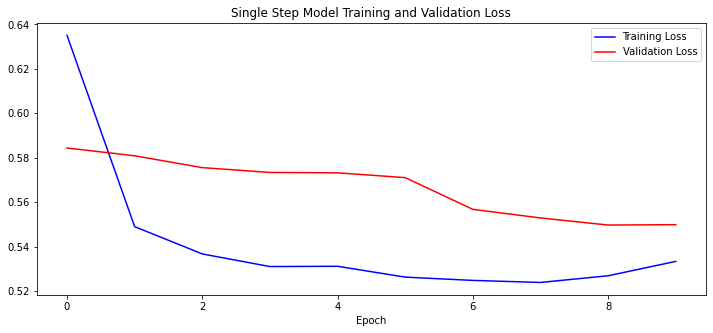

In [39]:
plot_train_history(single_step_model_history, 'Single Step Model Training and Validation Loss')

In [ ]:
Based on the graph above, this model could be good because the loss value (training and validation) are roughly similar. But, we need more hyperparameter tuning to reduce the model loss value.

## Multi Step Model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

This multistep model used to predict numbers of future data using LSTM method by using the past_history data

In [40]:
past_history = 24 * 7
future_target = 24 * 3
STEP = 24 # We can customize how many time steps that we want to use

x_train_multi, y_train_multi = multivariate_data(dt_multivariate, dt_multivariate[:, 1], 0, TRAIN_SPLIT, past_history, 
                                                   future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dt_multivariate, dt_multivariate[:, 1], TRAIN_SPLIT, None, past_history, 
                                               future_target, STEP)

In [41]:
print(len(x_train_multi), len(y_train_multi))
print(len(x_val_multi), len(y_val_multi))

158786 158786
105562 105562


In [42]:
print(x_train_single.shape, x_val_single.shape)
print()
print(y_train_single.shape, y_val_single.shape)

(158786, 7, 5) (105562, 7, 5)

(158786,) (105562,)


In [43]:
# Test at a single data point
print('Single window of past history: {}'.format(x_train_multi[0].shape))
print('\nTarget temperature to predict: {}'.format(y_train_multi[0].shape))

Single window of past history: (7, 5)

Target temperature to predict: (72,)


In [44]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [45]:
#Plotting a sample data-point.
def multi_step_plot(history, true_future, prediction):

    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

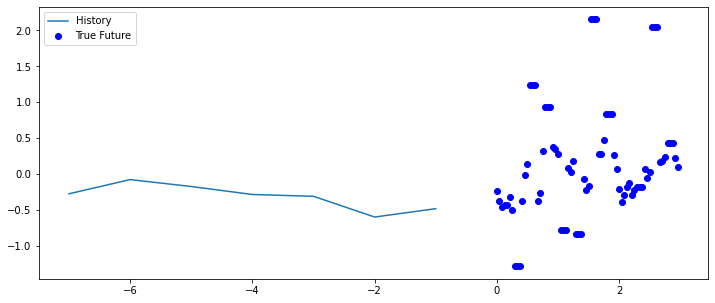

In [46]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [47]:
# Normal Sequential model
tf.keras.backend.clear_session()

# 5 layer LSTM
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dense(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target)) # the number output layer should be the same as future target
multi_step_model.compile(optimizer='sgd', loss='mae')

multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4864      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 72)                2376      
Total params: 10,408
Trainable params: 10,408
Non-trainable params: 0
_________________________________________________________________


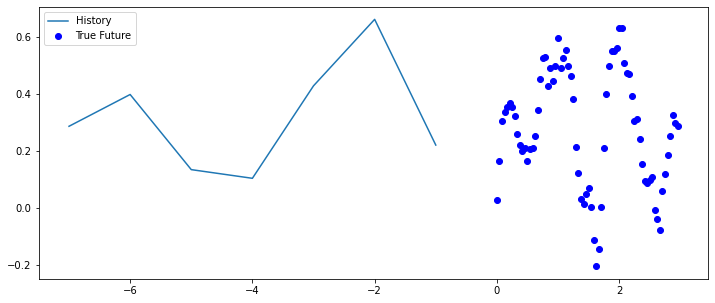

In [48]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
EPOCHS = 50 # 10
STEPS_PER_EPOCH = 180 # 200
VALIDATION_STEPS = 50 # 50

multi_step_model_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=VALIDATION_STEPS)

Train for 180 steps, validate for 50 steps
Epoch 1/50
180/180 [==============================] - 3s 14ms/step - loss: 0.8033 - val_loss: 0.7926
Epoch 2/50
180/180 [==============================] - 1s 8ms/step - loss: 0.8008 - val_loss: 0.7911
Epoch 3/50
180/180 [==============================] - 1s 8ms/step - loss: 0.7974 - val_loss: 0.7896
Epoch 4/50
180/180 [==============================] - 1s 8ms/step - loss: 0.7951 - val_loss: 0.7882
Epoch 5/50
180/180 [==============================] - 1s 8ms/step - loss: 0.8003 - val_loss: 0.7869
Epoch 6/50
180/180 [==============================] - 1s 8ms/step - loss: 0.7931 - val_loss: 0.7857
Epoch 7/50
180/180 [==============================] - 1s 8ms/step - loss: 0.7842 - val_loss: 0.7844
Epoch 8/50
180/180 [==============================] - 1s 8ms/step - loss: 0.7965 - val_loss: 0.7834
Epoch 9/50
180/180 [==============================] - 1s 8ms/step - loss: 0.7948 - val_loss: 0.7825
Epoch 10/50
180/180 [==============================] - 1

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
plot_train_history(multi_step_model_history, 'Multi Step Model Training and Validation Loss')

##Predict a multi-step future
Let's now have a look at how well the network has learnt to predict the future.

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])